In [1]:
from collections import defaultdict
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os 

from tqdm import tqdm
from collections import Counter
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit
from scipy.stats import hmean
from sklearn.metrics import auc
from matplotlib import rcParams
import matplotlib.lines as mlines
from utils import read_fasta, calculate_rg, run_tmscore
from scipy.stats import mannwhitneyu

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'

In [2]:
fig_dir = '../data/figures'
os.makedirs(fig_dir, exist_ok=True)

data_dir = '../data'

In [3]:
def load_ids(file):
    with open(file, 'r') as f:
        ids = [line.strip() for line in f]
    return ids


def extract_lddt_rsa_ss(df=None, idrs_df=None):
    """
    Extract lddt, rsa, and ss from the AF2 dataframe for the IDR regions
    """ 
    idr_count = 0 
    plddt_list = []
    plddt_avg_list = []

    rsa_list = []
    rsa_avg_list = []

    ss_list = []

    dfs = [] 

    region_pos = [] # position of the region in the sequence: N-terminal, C-terminal, internal, IDP

    for i,row in idrs_df.iterrows():
        disprot_id = row['DisProt_id']
        start = row['start']
        end = row['end']
        temp_df = df[df['name'] == disprot_id].reset_index(drop=True)
        
        plddt_list.extend(temp_df.loc[start-1:end-1 , 'lddt'].tolist())
        rsa_list.extend(temp_df.loc[start-1:end-1 , 'rsa'].tolist())
        ss_list.extend(temp_df.loc[start-1:end-1 , 'ss'].tolist())

        plddt_avg_list.append(temp_df.loc[start-1:end-1 , 'lddt'].mean())
        rsa_avg_list.append(temp_df.loc[start-1:end-1 , 'rsa'].mean())

        region_pos.append(row['terminal'])


        dfs.append(temp_df.iloc[start-1:end]) 
        idr_count += 1

    concatenated_df = pd.concat(dfs) 
    concatenated_df.reset_index(drop=True, inplace=True) 
    # print(concatenated_df.shape) 
    print('IDR count:', idr_count)
    return plddt_list, rsa_list, ss_list, plddt_avg_list, rsa_avg_list, region_pos, concatenated_df

def custom_dict():
    return {"target": None, "AlphaFold2-rsa_f1": None, "AlphaFold2-plddt_f1": None, "AlphaFold3-rsa_f1": None, "AlphaFold3-plddt_f1": None}

def bootstrap_ci(x, y, n_bootstraps=1000, ci=95):
    n = len(x)
    corrs = []
    for _ in range(n_bootstraps):
        idx = np.random.choice(np.arange(n), size=n, replace=True)
        corr, _ = pearsonr(np.array(x)[idx], np.array(y)[idx])
        corrs.append(corr)
    lower = np.percentile(corrs, (100 - ci) / 2)
    upper = np.percentile(corrs, 100 - (100 - ci) / 2)
    std = np.std(corrs)
    return lower, upper, std


def calculate_binary_state(score,thr):
    if score >= thr:
        return 1
    else:
        return 0

def read_caid_file(file_path, thr):
    results = []
    acc = ''
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                acc = line.strip()[1:]
            else:
                pos, aa, score = line.strip().split()
                state = calculate_binary_state(float(score), thr)
                results.append((acc, int(pos), aa, float(score), state))
    return results

def compute_label(row, method):
    if int(row['label']) == 1 and row[method] == 1:
        return 'TP'
    elif int(row['label']) == 1 and row[method] == 0:
        return 'FN'
    elif int(row['label']) == 0 and row[method] == 1:
        return 'FP'
    elif int(row['label']) == 0 and row[method] == 0:
        return 'TN'
    
def compute_confusion_matrix(values1, values2, rownames, colnames):
    conf_mat = pd.crosstab(values1, values2, rownames=[rownames], colnames=[colnames])
    labels = sorted(set(conf_mat.index).union(set(conf_mat.columns)))
    conf_mat = conf_mat.reindex(index=labels, columns=labels, fill_value=0)

    # Get diagonal values (only works if rows and columns are aligned)
    diag_values = np.array([conf_mat.loc[l, l] for l in labels])

    # Sort labels by diagonal values (descending)
    sorted_labels = [label for _, label in sorted(zip(-diag_values, labels))]

    # Reorder rows and columns
    conf_mat_sorted = conf_mat.loc[sorted_labels, sorted_labels]
    return conf_mat_sorted

def draw_confusion_matrix(conf_mat, output_file,text_size=10,figsize=(4,4)):
    plt.figure(figsize=figsize)
    ax=sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',annot_kws={"size": text_size})
    ax.xaxis.set_label_position("top")
    plt.tick_params(axis='both', which='major', labelsize=text_size, labelbottom = False, bottom=False, top = False, labeltop=True)

    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()
    plt.close()

def make_path(directory,acc):
    if os.path.exists(os.path.join(directory,f'{acc}.cif')):
        return os.path.join(directory,f'{acc}.cif')
    elif os.path.exists(os.path.join(directory,f'{acc}.pdb')):
        return os.path.join(directory,f'{acc}.pdb')

In [4]:
af2_all_df = pd.read_csv(f'{data_dir}/disorder_prediction/AF2/AlphaFold2_data.tsv', sep='\t') # the tsv is the output of AlphaFold-disorder package applied on AF2 strutures
af3_all_df = pd.read_csv(f'{data_dir}/disorder_prediction/AF3/AlphaFold3_data.tsv', sep='\t') # the tsv is the output of AlphaFold-disorder package applied on AF3 strutures

print(af2_all_df)
print(af3_all_df)

af2_all_df['unique'] = af2_all_df['name'] + '_' + af2_all_df['pos'].astype(str) + '_' + af2_all_df['aa']
af3_all_df['unique'] = af3_all_df['name'] + '_' + af3_all_df['pos'].astype(str)  + '_' + af3_all_df['aa']

af2_all_df = af2_all_df.set_index('unique').reindex(af3_all_df['unique']).reset_index()

af2_all_df['pos'] = af2_all_df['pos'].astype(int)
print(af2_all_df)
print(af3_all_df)


           name  pos aa   lddt  disorder    rsa ss
0       DP04026    1  M  0.503     0.497  1.000  -
1       DP04026    2  S  0.446     0.554  0.915  P
2       DP04026    3  E  0.434     0.566  0.933  P
3       DP04026    4  P  0.450     0.550  0.890  P
4       DP04026    5  S  0.461     0.539  0.777  -
...         ...  ... ..    ...       ...    ... ..
160417  DP04229  222  S  0.976     0.024  0.469  E
160418  DP04229  223  R  0.973     0.027  0.286  E
160419  DP04229  224  F  0.972     0.028  0.274  E
160420  DP04229  225  V  0.975     0.025  0.028  E
160421  DP04229  226  G  0.911     0.089  0.179  -

[160422 rows x 7 columns]
           name  pos aa   lddt  disorder    rsa ss
0       DP04208    1  M  0.596     0.404  1.000  -
1       DP04208    2  A  0.704     0.296  0.981  P
2       DP04208    3  S  0.639     0.361  0.885  P
3       DP04208    4  P  0.644     0.356  0.912  P
4       DP04208    5  A  0.640     0.360  0.934  P
...         ...  ... ..    ...       ...    ... ..
1604

In [5]:
proteins_df = pd.read_csv(f'{data_dir}/processed/parsed_fasta/disorder_pdb_proteins.csv')
proteins_df

,DisProt_id,Uniprot_id,seq_len,disorder_count,disorder_content,order_count,order_content,na_count,na_content,annotated_content,category,sequence,labels
0,DP02732,Q8IWJ2,1684,23,0.013658,38,0.022565,1623,0.963777,0.036223,IDR,MEDLVQDGVASPATPGTGKSKLETLPKEDLIKFAKKQMMLIQKAKS...,----------------------------------------------...
1,DP03745,Q8VHC3,145,35,0.241379,86,0.593103,24,0.165517,0.834483,IDR,MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...,------------------------1111111111000000000000...
2,DP03748,P75862,180,12,0.066667,168,0.933333,0,0.000000,1.000000,IDR,MRIKPDDNWRWYYDEEHDRMMLDLANGMLFRSRFARKMLTPDAFSP...,0000000000000000000000000000000000000000000000...
3,DP03749,Q92871,262,11,0.041985,247,0.942748,4,0.015267,0.984733,IDR,MAVTAQAARRKERVLCLFDVDGTLTPARQKIDPEVAAFLQKLRSRV...,1111111111100000000000000000000000000000000000...
4,DP03758,Q96ST2,819,197,0.240537,143,0.174603,479,0.584860,0.415140,IDR,MDSEYYSGDQSDDGGATPVQDERDSGSDGEDDVNEQHSGSDTGSVE...,----------------------------------------------...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,DP04397,Q5ZTK6,873,10,0.011455,747,0.855670,116,0.132875,0.867125,IDR,MFGFIKKVLDFFGVDQSEDNPSETAVETTDVSTKIKTTDTTQEESS...,----------------------------------------------...
315,DP04398,Q5ZTK4,1499,458,0.305537,690,0.460307,351,0.234156,0.765844,IDR,MPKYVEGVELTQEGMHAIFARMGYGDITSGSIYNGVPTIDTGALNR...,0000000000000000000000000000000000000000000000...
316,DP04399,P08062,556,150,0.269784,386,0.694245,20,0.035971,0.964029,IDR,MDPKAEGNGENITETAAGNVETSDFVNLKRQKREGVNSTGMSEIDM...,1111111111111111111111111111111111111111111111...
317,DP04401,A0AAI8ESY0,255,102,0.400000,0,0.000000,153,0.600000,0.400000,PosReg,MKLFNRYRVALLSALPLALCALSAAAQVVQEYEYAPDRIYQVRTGL...,----------------------------------------------...


In [6]:
idrs_df = pd.read_csv(f'{data_dir}/processed/parsed_fasta/disorder_pdb_regions.csv')
idrs_df['unique_id'] = idrs_df['DisProt_id'] + '_' + idrs_df['start'].astype(str) + '_' + idrs_df['end'].astype(str)
idrs_df

,DisProt_id,Uniprot_id,start,end,length,terminal,sequence,unique_id
0,DP02732,Q8IWJ2,1547,1569,23,Internal,LEPPLWHAEFTKEELVQKLSSTT,DP02732_1547_1569
1,DP03745,Q8VHC3,25,34,10,Internal,TNYRPDWNRL,DP03745_25_34
2,DP03745,Q8VHC3,121,145,25,C,EAQVPPEYLWAPAKPPEEASEHDDL,DP03745_121_145
3,DP03748,P75862,169,180,12,C,VNVDSFSLEQAV,DP03748_169_180
4,DP03749,Q92871,1,11,11,N,MAVTAQAARRK,DP03749_1_11
...,...,...,...,...,...,...,...,...
450,DP04399,P08062,1,111,111,N,MDPKAEGNGENITETAAGNVETSDFVNLKRQKREGVNSTGMSEIDM...,DP04399_1_111
451,DP04399,P08062,518,556,39,C,EPSDRYSRAFVRPEPALPPISDSRRTYESRPRGPTVNSL,DP04399_518_556
452,DP04401,A0AAI8ESY0,154,255,102,C,NAKILKDRRYYYDYDYATRTKKSWLIPSRVYDDGKFTYINMDLTRF...,DP04401_154_255
453,DP04416,O53692,1,14,14,N,MSLLDAHIPQLVAS,DP04416_1_14


In [7]:
af3_plddt_list, af3_rsa_list, af3_ss_list, af3_plddt_avg_list, af3_rsa_avg_list, region_positions_af3, af3_idrs_df = extract_lddt_rsa_ss(df=af3_all_df, idrs_df=idrs_df)
af2_plddt_list, af2_rsa_list, af2_ss_list, af2_plddt_avg_list, af2_rsa_avg_list, region_positions_af2, af2_idrs_df = extract_lddt_rsa_ss(df=af2_all_df, idrs_df=idrs_df)
print(region_positions_af3  == region_positions_af2)


IDR count: 455
IDR count: 455
True


In [8]:
af2_idrs_df

,unique,name,pos,aa,lddt,disorder,rsa,ss
0,DP02732_1547_L,DP02732,1547,L,0.366,0.634,1.000,-
1,DP02732_1548_E,DP02732,1548,E,0.300,0.700,0.912,-
2,DP02732_1549_P,DP02732,1549,P,0.396,0.604,0.669,-
3,DP02732_1550_P,DP02732,1550,P,0.335,0.665,0.904,-
4,DP02732_1551_L,DP02732,1551,L,0.306,0.694,0.774,-
...,...,...,...,...,...,...,...,...
31396,DP04416_93_T,DP04416,93,T,0.758,0.242,0.789,H
31397,DP04416_94_Y,DP04416,94,Y,0.674,0.326,0.851,-
31398,DP04416_95_T,DP04416,95,T,0.667,0.333,0.803,-
31399,DP04416_96_G,DP04416,96,G,0.618,0.382,0.548,-


In [9]:
af3_idrs_df

,name,pos,aa,lddt,disorder,rsa,ss,unique
0,DP02732,1547,L,0.423,0.577,1.000,-,DP02732_1547_L
1,DP02732,1548,E,0.465,0.535,0.892,P,DP02732_1548_E
2,DP02732,1549,P,0.423,0.577,0.838,P,DP02732_1549_P
3,DP02732,1550,P,0.419,0.581,0.882,P,DP02732_1550_P
4,DP02732,1551,L,0.431,0.569,1.000,-,DP02732_1551_L
...,...,...,...,...,...,...,...,...
31396,DP04416,93,T,0.801,0.199,0.676,H,DP04416_93_T
31397,DP04416,94,Y,0.815,0.185,0.869,H,DP04416_94_Y
31398,DP04416,95,T,0.745,0.255,0.859,T,DP04416_95_T
31399,DP04416,96,G,0.694,0.306,0.750,T,DP04416_96_G


In [10]:
idrs_df['length'].sum()

np.int64(31401)

In [11]:
print(Counter(region_positions_af2))
print(Counter(region_positions_af3))

Counter({'Internal': 245, 'C': 93, 'N': 91, 'IDP': 26})
Counter({'Internal': 245, 'C': 93, 'N': 91, 'IDP': 26})


In [12]:
print(len(af3_plddt_list), len(af3_rsa_list), len(af3_ss_list)) 
print(len(af2_plddt_list), len(af2_rsa_list), len(af2_ss_list))

31401 31401 31401
31401 31401 31401


In [13]:
print(af2_all_df[af2_all_df['name'] == 'DP04016']['lddt'].mean(), af3_all_df[af3_all_df['name'] == 'DP04016']['lddt'].mean())

0.42668031496062986 0.5751165354330708


# Predicted Secondary Structure Content in IDRs

In [14]:
print(af2_all_df)

               unique     name  pos aa   lddt  disorder    rsa ss
0         DP04208_1_M  DP04208    1  M  0.412     0.588  1.000  -
1         DP04208_2_A  DP04208    2  A  0.425     0.575  0.953  -
2         DP04208_3_S  DP04208    3  S  0.489     0.511  0.923  P
3         DP04208_4_P  DP04208    4  P  0.494     0.506  0.934  P
4         DP04208_5_A  DP04208    5  A  0.511     0.489  0.962  P
...               ...      ...  ... ..    ...       ...    ... ..
160417  DP04229_222_S  DP04229  222  S  0.976     0.024  0.469  E
160418  DP04229_223_R  DP04229  223  R  0.973     0.027  0.286  E
160419  DP04229_224_F  DP04229  224  F  0.972     0.028  0.274  E
160420  DP04229_225_V  DP04229  225  V  0.975     0.025  0.028  E
160421  DP04229_226_G  DP04229  226  G  0.911     0.089  0.179  -

[160422 rows x 8 columns]


In [15]:
print(af2_idrs_df)

               unique     name   pos aa   lddt  disorder    rsa ss
0      DP02732_1547_L  DP02732  1547  L  0.366     0.634  1.000  -
1      DP02732_1548_E  DP02732  1548  E  0.300     0.700  0.912  -
2      DP02732_1549_P  DP02732  1549  P  0.396     0.604  0.669  -
3      DP02732_1550_P  DP02732  1550  P  0.335     0.665  0.904  -
4      DP02732_1551_L  DP02732  1551  L  0.306     0.694  0.774  -
...               ...      ...   ... ..    ...       ...    ... ..
31396    DP04416_93_T  DP04416    93  T  0.758     0.242  0.789  H
31397    DP04416_94_Y  DP04416    94  Y  0.674     0.326  0.851  -
31398    DP04416_95_T  DP04416    95  T  0.667     0.333  0.803  -
31399    DP04416_96_G  DP04416    96  G  0.618     0.382  0.548  -
31400    DP04416_97_F  DP04416    97  F  0.586     0.414  1.000  -

[31401 rows x 8 columns]


In [16]:
af2_coil_count = af2_all_df[af2_all_df['ss'] == '-'].shape[0]
af2_helix_count = af2_all_df[af2_all_df['ss'] == 'H'].shape[0]
af2_sheet_count = af2_all_df[af2_all_df['ss'] == 'E'].shape[0]

af2_coil_avg_plddt = af2_all_df[af2_all_df['ss'] == '-']['lddt'].mean()
af2_helix_avg_plddt = af2_all_df[af2_all_df['ss'] == 'H']['lddt'].mean()
af2_sheet_avg_plddt = af2_all_df[af2_all_df['ss'] == 'E']['lddt'].mean()

print('***********************************************')
print('***********************************************')

print('AlphaFold2 Statistics in Disorder-PDB dataset :')
print(f'coil count: {af2_coil_count}, avg_plddt:{round(af2_coil_avg_plddt,3)}')
print(f'helix count: {af2_helix_count}, avg_plddt:{round(af2_helix_avg_plddt,3)}')
print(f'sheet count: {af2_sheet_count}, avg_plddt:{round(af2_sheet_avg_plddt,3)}')

af3_coil_count = af3_all_df[af3_all_df['ss'] == '-'].shape[0]
af3_helix_count = af3_all_df[af3_all_df['ss'] == 'H'].shape[0]
af3_sheet_count = af3_all_df[af3_all_df['ss'] == 'E'].shape[0]

af3_coil_avg_plddt = af3_all_df[af3_all_df['ss'] == '-']['lddt'].mean()
af3_helix_avg_plddt = af3_all_df[af3_all_df['ss'] == 'H']['lddt'].mean()
af3_sheet_avg_plddt = af3_all_df[af3_all_df['ss'] == 'E']['lddt'].mean()


print('***********************************************')
print('***********************************************')

print('AlphaFold3 Statistics in Disorder-PDB dataset :')
print(f'coil count: {af3_coil_count}, avg_plddt:{round(af3_coil_avg_plddt,3)}')
print(f'helix count: {af3_helix_count}, avg_plddt:{round(af3_helix_avg_plddt,3)}')
print(f'sheet count: {af3_sheet_count}, avg_plddt:{round(af3_sheet_avg_plddt,3)}')


***********************************************
***********************************************
AlphaFold2 Statistics in Disorder-PDB dataset :
coil count: 54983, avg_plddt:0.506
helix count: 50389, avg_plddt:0.842
sheet count: 19440, avg_plddt:0.925
***********************************************
***********************************************
AlphaFold3 Statistics in Disorder-PDB dataset :
coil count: 51201, avg_plddt:0.504
helix count: 52477, avg_plddt:0.857
sheet count: 20881, avg_plddt:0.89


In [17]:
af2_coil_count = af2_idrs_df[af2_idrs_df['ss'] == '-'].shape[0]
af2_helix_count = af2_idrs_df[af2_idrs_df['ss'] == 'H'].shape[0]
af2_sheet_count = af2_idrs_df[af2_idrs_df['ss'] == 'E'].shape[0]

af2_coil_avg_plddt = af2_idrs_df[af2_idrs_df['ss'] == '-']['lddt'].mean()
af2_helix_avg_plddt = af2_idrs_df[af2_idrs_df['ss'] == 'H']['lddt'].mean()
af2_sheet_avg_plddt = af2_idrs_df[af2_idrs_df['ss'] == 'E']['lddt'].mean()

print('***********************************************')
print('***********************************************')

print('AlphaFold2 Statistics in Disorder-PDB IDRs :')
print(f'coil count: {af2_coil_count}, avg_plddt:{round(af2_coil_avg_plddt,3)}')
print(f'helix count: {af2_helix_count}, avg_plddt:{round(af2_helix_avg_plddt,3)}')
print(f'sheet count: {af2_sheet_count}, avg_plddt:{round(af2_sheet_avg_plddt,3)}')

af3_coil_count = af3_idrs_df[af3_idrs_df['ss'] == '-'].shape[0]
af3_helix_count = af3_idrs_df[af3_idrs_df['ss'] == 'H'].shape[0]
af3_sheet_count = af3_idrs_df[af3_idrs_df['ss'] == 'E'].shape[0]

af3_coil_avg_plddt = af3_idrs_df[af3_idrs_df['ss'] == '-']['lddt'].mean()
af3_helix_avg_plddt = af3_idrs_df[af3_idrs_df['ss'] == 'H']['lddt'].mean()
af3_sheet_avg_plddt = af3_idrs_df[af3_idrs_df['ss'] == 'E']['lddt'].mean()

print('***********************************************')
print('***********************************************')

print('AlphaFold3 Statistics in Disorder-PDB IDRs :')
print(f'coil count: {af3_coil_count}, avg_plddt:{round(af3_coil_avg_plddt,3)}')
print(f'helix count: {af3_helix_count}, avg_plddt:{round(af3_helix_avg_plddt,3)}')
print(f'sheet count: {af3_sheet_count}, avg_plddt:{round(af3_sheet_avg_plddt,3)}')


***********************************************
***********************************************
AlphaFold2 Statistics in Disorder-PDB IDRs :
coil count: 18511, avg_plddt:0.416
helix count: 6610, avg_plddt:0.674
sheet count: 591, avg_plddt:0.84
***********************************************
***********************************************
AlphaFold3 Statistics in Disorder-PDB IDRs :
coil count: 17683, avg_plddt:0.39
helix count: 7162, avg_plddt:0.726
sheet count: 632, avg_plddt:0.813


In [18]:
coil_stat, coil_p = mannwhitneyu(af2_all_df[af2_all_df['ss'] == '-']['lddt'], af3_all_df[af3_all_df['ss'] == '-']['lddt'], alternative='two-sided')
helix_stat, helix_p = mannwhitneyu(af2_all_df[af2_all_df['ss'] == 'H']['lddt'], af3_all_df[af3_all_df['ss'] == 'H']['lddt'], alternative='two-sided')
sheet_stat, sheet_p = mannwhitneyu(af2_all_df[af2_all_df['ss'] == 'E']['lddt'], af3_all_df[af3_all_df['ss'] == 'E']['lddt'], alternative='two-sided')

print(f'Mann-Whitney U test for Coil distributions: stat = {coil_stat} , p-value = {coil_p}')
print(f'Mann-Whitney U test for Helix distributions: stat = {helix_stat} , p-value = {helix_p}')
print(f'Mann-Whitney U test for Sheet distributions: stat = {sheet_stat} , p-value = {sheet_p}')


Mann-Whitney U test for Coil distributions: stat = 1531171532.0 , p-value = 2.4143693813735177e-135
Mann-Whitney U test for Helix distributions: stat = 1261381079.0 , p-value = 2.7340995309672345e-37
Mann-Whitney U test for Sheet distributions: stat = 217850560.5 , p-value = 3.2028554805800224e-37


In [48]:
coil_stat, coil_p = mannwhitneyu(af2_idrs_df[af2_idrs_df['ss'] == '-']['lddt'], af3_idrs_df[af3_idrs_df['ss'] == '-']['lddt'], alternative='two-sided')
helix_stat, helix_p = mannwhitneyu(af2_idrs_df[af2_idrs_df['ss'] == 'H']['lddt'], af3_idrs_df[af3_idrs_df['ss'] == 'H']['lddt'], alternative='two-sided')
sheet_stat, sheet_p = mannwhitneyu(af2_idrs_df[af2_idrs_df['ss'] == 'E']['lddt'], af3_idrs_df[af3_idrs_df['ss'] == 'E']['lddt'], alternative='two-sided')

print(f'Mann-Whitney U test for Coil distributions: stat = {coil_stat} , p-value = {coil_p}')
print(f'Mann-Whitney U test for Helix distributions: stat = {helix_stat} , p-value = {helix_p}')
print(f'Mann-Whitney U test for Sheet distributions: stat = {sheet_stat} , p-value = {sheet_p}')

Mann-Whitney U test for Coil distributions: stat = 196077919.5 , p-value = 2.088237353068001e-233
Mann-Whitney U test for Helix distributions: stat = 20547711.5 , p-value = 6.344073329183024e-41
Mann-Whitney U test for Sheet distributions: stat = 200665.0 , p-value = 0.024233886024622953


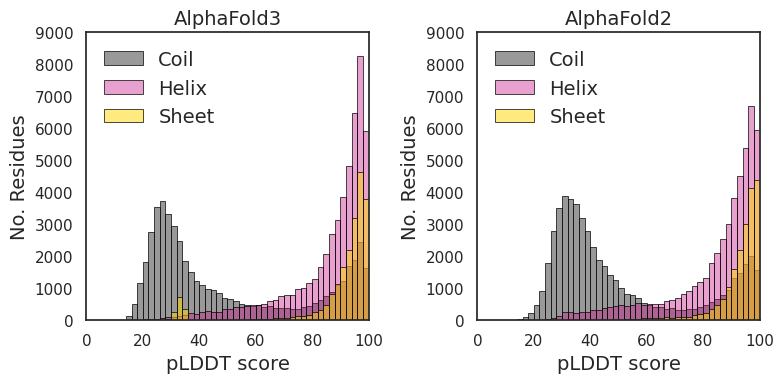

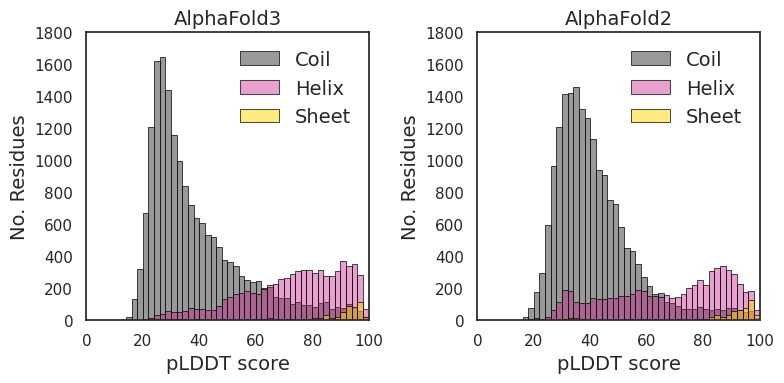

In [19]:
plt.figure(figsize=(8,4))
sns.set_theme(style="white")
plt.subplot(1, 2, 1)
sns.histplot(af3_all_df[af3_all_df['ss'] == '-']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.8, label='Coil', color =  'grey',)
sns.histplot(af3_all_df[af3_all_df['ss'] == 'H']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.4, label='Helix', color= 'mediumvioletred')
sns.histplot(af3_all_df[af3_all_df['ss'] == 'E']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.5, label='Sheet', color='gold')
plt.legend(frameon=False,fontsize=14)
plt.xlim(0,100)
plt.ylim(0,9000)
plt.xlabel('pLDDT score',fontsize=14)
plt.ylabel('No. Residues',fontsize=14)
plt.title('AlphaFold3', fontsize=14)


plt.subplot(1, 2, 2)
sns.histplot(af2_all_df[af2_all_df['ss'] == '-']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.8, label='Coil', color =  'grey') 
sns.histplot(af2_all_df[af2_all_df['ss'] == 'H']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.4, label='Helix', color= 'mediumvioletred')
sns.histplot(af2_all_df[af2_all_df['ss'] == 'E']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.5, label='Sheet', color='gold')
plt.legend(frameon=False,fontsize=14)
plt.ylim(0,9000)
plt.xlim(0,100)
plt.xlabel('pLDDT score',fontsize=14)
plt.ylabel('No. Residues',fontsize=14)
plt.title('AlphaFold2', fontsize=14)

plt.tight_layout()
plt.savefig(f'{data_dir}/figures/figure_S_3_A_B.png',dpi=300)
plt.show()
plt.close()


plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
sns.histplot(af3_idrs_df[af3_idrs_df['ss'] == '-']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.8, label='Coil', color =  'grey')
sns.histplot(af3_idrs_df[af3_idrs_df['ss'] == 'H']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.4, label='Helix',color= 'mediumvioletred')
sns.histplot(af3_idrs_df[af3_idrs_df['ss'] == 'E']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.5, label='Sheet', color='gold')
plt.legend(frameon=False,fontsize=14)
# plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
plt.ylim(0,1800)
plt.xlim(0,100)
plt.xlabel('pLDDT score',fontsize=14)
plt.ylabel('No. Residues',fontsize=14)
plt.title('AlphaFold3', fontsize=14)

plt.subplot(1, 2, 2)
sns.histplot(af2_idrs_df[af2_idrs_df['ss'] == '-']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.8, label='Coil', color =  'grey')
sns.histplot(af2_idrs_df[af2_idrs_df['ss'] == 'H']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.4, label='Helix', color= 'mediumvioletred')
sns.histplot(af2_idrs_df[af2_idrs_df['ss'] == 'E']['lddt']*100,bins=list(np.arange(0,102,2)), edgecolor='black',linewidth=0.5,alpha=0.5, label='Sheet', color='gold')
plt.legend(frameon=False,fontsize=14)
plt.ylim(0,1800)
plt.xlim(0,100)
plt.xlabel('pLDDT score',fontsize=14)
plt.ylabel('No. Residues',fontsize=14)
plt.title('AlphaFold2', fontsize=14)
plt.tight_layout()
plt.savefig(f'{data_dir}/figures/figure_3_A_B.png',dpi=300)
plt.show()
plt.close()

In [20]:
merged = pd.merge(af2_idrs_df, af3_idrs_df, on=['name', 'pos', 'aa','unique'], suffixes=('_af2', '_af3'))
c_c_2_3 = merged[(merged['ss_af2'] == '-') & (merged['ss_af3'] == '-') & (merged['lddt_af2'] > merged['lddt_af3'])].shape[0]
c_c_3_2 = merged[(merged['ss_af2'] == '-') & (merged['ss_af3'] == '-') & (merged['lddt_af3'] > merged['lddt_af2'])].shape[0]
c_c_equal = merged[(merged['ss_af2'] == '-') & (merged['ss_af3'] == '-') & (merged['lddt_af3'] == merged['lddt_af2'])].shape[0]

h_h_2_3 = merged[(merged['ss_af2'] == 'H') & (merged['ss_af3'] == 'H') & (merged['lddt_af2'] > merged['lddt_af3'])].shape[0]
h_h_3_2 = merged[(merged['ss_af2'] == 'H') & (merged['ss_af3'] == 'H') & (merged['lddt_af3'] > merged['lddt_af2'])].shape[0]
h_h_equal= merged[(merged['ss_af2'] == 'H') & (merged['ss_af3'] == 'H') & (merged['lddt_af3'] == merged['lddt_af2'])].shape[0]


In [21]:
print(merged)

               unique     name   pos aa  lddt_af2  disorder_af2  rsa_af2  \
0      DP02732_1547_L  DP02732  1547  L     0.366         0.634    1.000   
1      DP02732_1548_E  DP02732  1548  E     0.300         0.700    0.912   
2      DP02732_1549_P  DP02732  1549  P     0.396         0.604    0.669   
3      DP02732_1550_P  DP02732  1550  P     0.335         0.665    0.904   
4      DP02732_1551_L  DP02732  1551  L     0.306         0.694    0.774   
...               ...      ...   ... ..       ...           ...      ...   
31396    DP04416_93_T  DP04416    93  T     0.758         0.242    0.789   
31397    DP04416_94_Y  DP04416    94  Y     0.674         0.326    0.851   
31398    DP04416_95_T  DP04416    95  T     0.667         0.333    0.803   
31399    DP04416_96_G  DP04416    96  G     0.618         0.382    0.548   
31400    DP04416_97_F  DP04416    97  F     0.586         0.414    1.000   

      ss_af2  lddt_af3  disorder_af3  rsa_af3 ss_af3  
0          -     0.423         0

In [22]:
coil_increase_fraction = round(c_c_3_2 / (c_c_2_3 + c_c_3_2 + c_c_equal), 2)
coil_decrease_fraction = round(c_c_2_3 / (c_c_2_3 + c_c_3_2 + c_c_equal), 2)

helix_increase_fraction = round(h_h_3_2 / (h_h_2_3 + h_h_3_2 + h_h_equal), 2)
helix_decrease_fraction = round(h_h_2_3 / (h_h_2_3 + h_h_3_2 + h_h_equal), 2)
print(f'coil increase fraction: {coil_increase_fraction:.2f}')
print(f'coil decrease fraction: {coil_decrease_fraction:.2f}')  
print(f'helix increase fraction: {helix_increase_fraction:.2f}')
print(f'helix decrease fraction: {helix_decrease_fraction:.2f}')

coil increase fraction: 0.37
coil decrease fraction: 0.63
helix increase fraction: 0.65
helix decrease fraction: 0.35


       pLDDT AF2 > AF3  pLDDT AF3 > AF2
Coil              9998             5826
Helix             2148             3971


<Figure size 500x400 with 0 Axes>

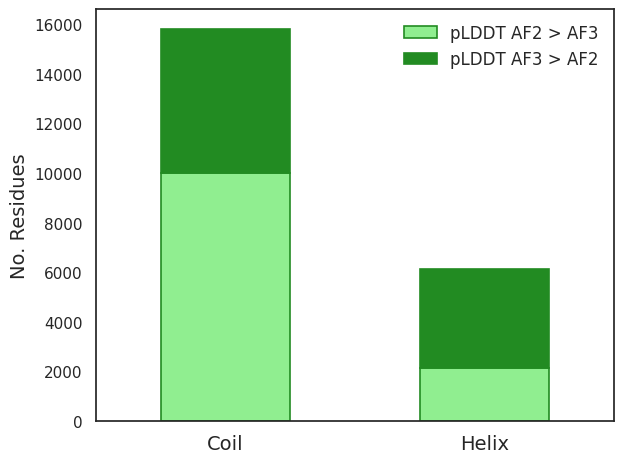

In [23]:
data = {
    'pLDDT AF2 > AF3': [c_c_2_3, h_h_2_3],
    # 'AF2 == AF3': [c_c_equal, h_h_equal],
    # 'pLDDT AF3 ≥ AF2': [c_c_3_2, h_h_3_2],
    'pLDDT AF3 > AF2': [c_c_3_2, h_h_3_2]

}
index = ['Coil', 'Helix']

texts = [coil_decrease_fraction, helix_decrease_fraction, coil_increase_fraction, helix_increase_fraction]

df = pd.DataFrame(data, index=index)
print(df)

custom_colors = ['lightgreen','forestgreen']
plt.figure(figsize=(5, 4))
ax = df.plot(kind='bar', stacked=True, color=custom_colors,linewidth=1.2, edgecolor='forestgreen')

plt.ylabel('No. Residues',fontsize=14)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=0,fontsize=14)
plt.tight_layout()
plt.savefig(f'{data_dir}/figures/figure_S_5.png', dpi=300)
plt.show()

# Confusion matrix of secondary structures across entire DisorderPDB dataset

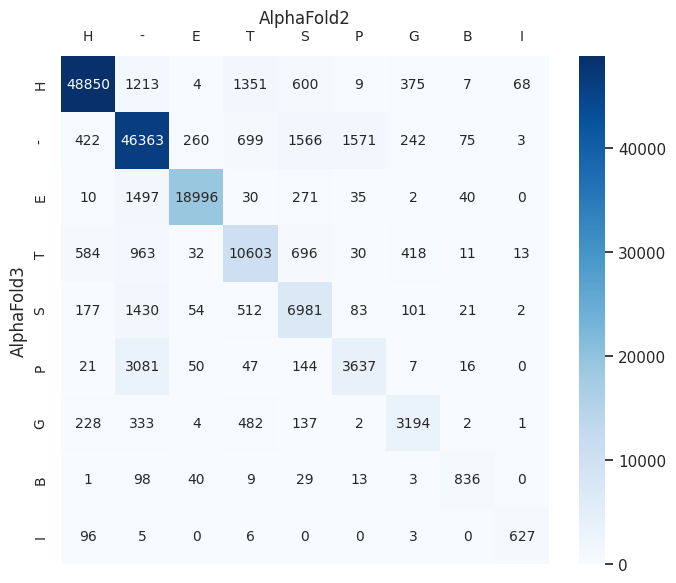

In [24]:
conf_mat = compute_confusion_matrix( af3_all_df['ss'], af2_all_df['ss'], 'AlphaFold3', 'AlphaFold2') #### TODO: fix the orders

draw_confusion_matrix(conf_mat,output_file=f'{data_dir}/figures/figure_unreleased_1.png',figsize=(7,6))

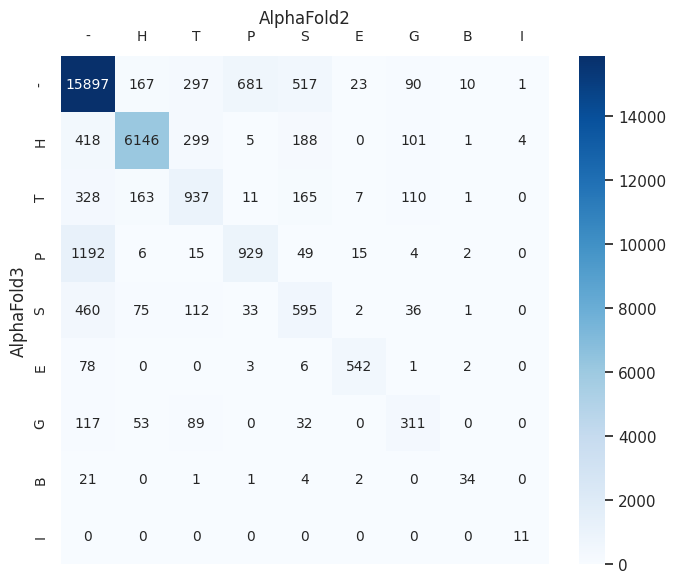

In [44]:
conf_mat = compute_confusion_matrix( af3_idrs_df['ss'], af2_idrs_df['ss'], 'AlphaFold3', 'AlphaFold2') 
draw_confusion_matrix(conf_mat,output_file=f'{data_dir}/figures/figure_unreleased_4.png',figsize=(7,6))

In [49]:
mask = (af2_idrs_df['ss'] == 'H') & (af3_idrs_df['ss'] == '-')
print(af2_idrs_df[mask]['name'].unique())
print(af2_idrs_df[mask]['name'].nunique())

['DP03818' 'DP03819' 'DP03826' 'DP03916' 'DP03931' 'DP03933' 'DP03939'
 'DP03942' 'DP03982' 'DP03996' 'DP03999' 'DP04006' 'DP04007' 'DP04017'
 'DP04018' 'DP04020' 'DP04133' 'DP04144' 'DP04148' 'DP04149' 'DP04154'
 'DP04155' 'DP04161' 'DP04174' 'DP04177' 'DP04184' 'DP04199' 'DP04203'
 'DP04236' 'DP04240' 'DP04242' 'DP04270' 'DP04271' 'DP04280' 'DP04287'
 'DP04290' 'DP04295' 'DP04299' 'DP04301' 'DP04376' 'DP04390' 'DP04399']
42


In [50]:
mask = (af2_idrs_df['ss'] == '-') & (af3_idrs_df['ss'] == 'H')
print(af2_idrs_df[mask]['name'].unique())
print(af2_idrs_df[mask]['name'].nunique())

['DP03745' 'DP03758' 'DP03759' 'DP03824' 'DP03912' 'DP03927' 'DP03931'
 'DP03935' 'DP03940' 'DP03941' 'DP03948' 'DP03972' 'DP03974' 'DP03980'
 'DP03984' 'DP03988' 'DP04006' 'DP04007' 'DP04008' 'DP04015' 'DP04016'
 'DP04017' 'DP04018' 'DP04019' 'DP04022' 'DP04024' 'DP04045' 'DP04052'
 'DP04062' 'DP04126' 'DP04141' 'DP04149' 'DP04152' 'DP04169' 'DP04172'
 'DP04175' 'DP04179' 'DP04180' 'DP04182' 'DP04186' 'DP04197' 'DP04198'
 'DP04200' 'DP04215' 'DP04221' 'DP04236' 'DP04244' 'DP04246' 'DP04255'
 'DP04258' 'DP04261' 'DP04263' 'DP04264' 'DP04268' 'DP04270' 'DP04271'
 'DP04275' 'DP04276' 'DP04280' 'DP04285' 'DP04286' 'DP04294' 'DP04296'
 'DP04298' 'DP04300' 'DP04328' 'DP04341' 'DP04343' 'DP04352' 'DP04376'
 'DP04379' 'DP04381' 'DP04388' 'DP04392' 'DP04395' 'DP04416']
76


# Confusion matrix for residues that their pLDDT increases in AlphaFold2 compared to AlphaFold2

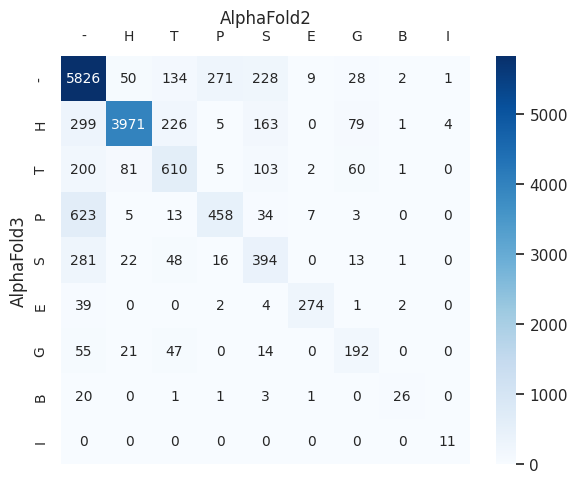

In [27]:
plddt_af3_gt_af2_condition = af3_idrs_df['lddt'] > af2_idrs_df['lddt']
plddt_af3_gt_af2_indices = af3_idrs_df.index[plddt_af3_gt_af2_condition]

AF3_plddt_af3_gt_af2 = af3_idrs_df.loc[plddt_af3_gt_af2_indices, 'ss'].tolist() 
AF2_plddt_af3_gt_af2 = af2_idrs_df.loc[plddt_af3_gt_af2_indices, 'ss'].tolist() 

conf_mat = compute_confusion_matrix(pd.Series(AF3_plddt_af3_gt_af2, name='AlphaFold3'), pd.Series(AF2_plddt_af3_gt_af2, name='AlphaFold2'),'AlphaFold3', 'AlphaFold2')
draw_confusion_matrix(conf_mat,output_file=f'{data_dir}/figures/figure_unreleased_2.png',figsize=(6,5))

# Confusion matrix for residues that their pLDDT decreases in AlphaFold2 compared to AlphaFold2

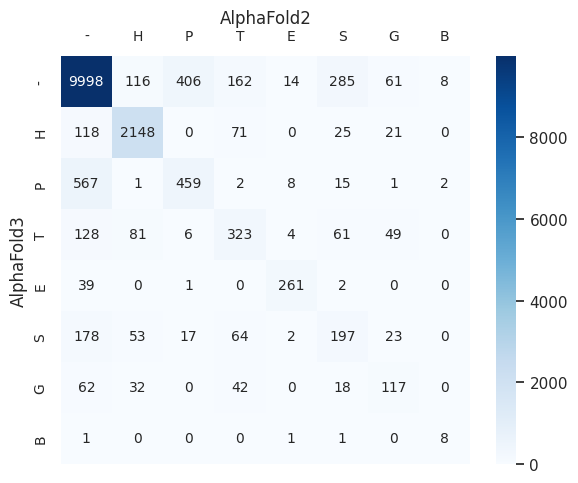

In [28]:
plddt_af3_lt_af2_condition = af3_idrs_df['lddt'] < af2_idrs_df['lddt']
plddt_af3_lt_af2_indices = af3_idrs_df.index[plddt_af3_lt_af2_condition]

AF3_plddt_af3_lt_af2 = af3_idrs_df.loc[plddt_af3_lt_af2_indices, 'ss'].tolist() 
AF2_plddt_af3_lt_af2 = af2_idrs_df.loc[plddt_af3_lt_af2_indices, 'ss'].tolist()

conf_mat = compute_confusion_matrix(pd.Series(AF3_plddt_af3_lt_af2, name='AlphaFold3'), pd.Series(AF2_plddt_af3_lt_af2, name='AlphaFold2'),'AlphaFold3', 'AlphaFold2')
draw_confusion_matrix(conf_mat,output_file=f'{data_dir}/figures/figure_unreleased_3.png',figsize=(6,5))



# Distribution of Secondary Structures

<Figure size 1800x1200 with 0 Axes>

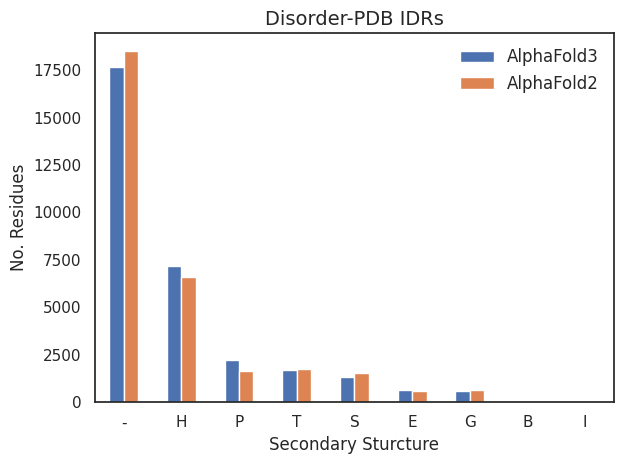

In [29]:
count1 = pd.Series(af3_ss_list).value_counts()
count2 = pd.Series(af2_ss_list).value_counts()

df = pd.DataFrame({
    'AlphaFold3': count1,
    'AlphaFold2': count2
}).fillna(0).astype(int)  
df_sorted = df.sort_values(by="AlphaFold3", ascending=False)

plt.figure(figsize=(6,4), dpi=300)
df_sorted.plot(kind='bar')
plt.gca().set_facecolor((1.0, 1, 1))
plt.title('Disorder-PDB IDRs',fontsize=14)
plt.xlabel('Secondary Sturcture')
plt.ylabel('No. Residues')
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{data_dir}/figures/figure_S_2_A.png', dpi=300)
plt.show()

<Figure size 1800x1200 with 0 Axes>

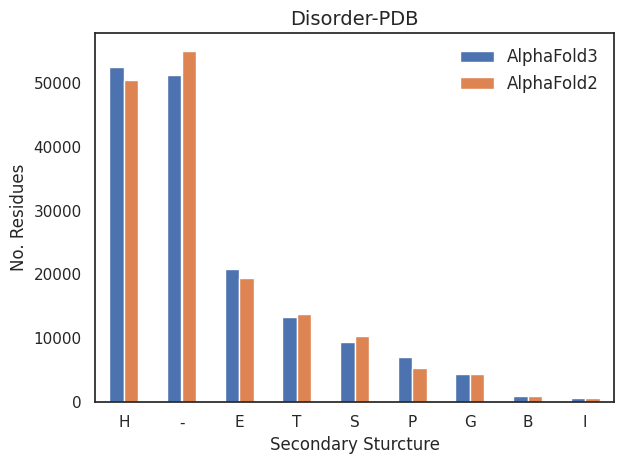

In [30]:
count1 = af3_all_df['ss'].value_counts()
count2 = af2_all_df['ss'].value_counts()

# Step 2: Combine counts into a DataFrame
df = pd.DataFrame({
    'AlphaFold3': count1,
    'AlphaFold2': count2
})
df_sorted = df.sort_values(by="AlphaFold3", ascending=False)
plt.figure(figsize=(6,4), dpi=300)
df_sorted.plot(kind='bar')

plt.gca().set_facecolor((1.0, 1, 1))
plt.title('Disorder-PDB',fontsize=14)
plt.xlabel('Secondary Sturcture',fontsize=12)
plt.ylabel('No. Residues',fontsize=12)
plt.xticks(rotation=0)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig(f'{data_dir}/figures/figure_S_2_B.png', dpi=300)
plt.show()

# pLDDT and RSA in IDRs

In [31]:
all_af2_plddt_list = (af2_all_df['lddt']*100).tolist()
all_af3_plddt_list = (af3_all_df['lddt']*100).tolist()
all_af2_rsa_list = af2_all_df['rsa'].tolist()
all_af3_rsa_list = af3_all_df['rsa'].tolist()

In [32]:
plddt_stat, plddt_p = mannwhitneyu(af2_plddt_list, af3_plddt_list, alternative='two-sided')
print(f'Mann-Whitney U test for pLDDT distributions: stat = {plddt_stat} , p-value = {plddt_p}')

rsa_stat, rsa_p = mannwhitneyu(af2_rsa_list, af3_rsa_list, alternative='two-sided')
print(f'Mann-Whitney U test for RSA distributions: stat = {rsa_stat} , p-value = {rsa_p}')

Mann-Whitney U test for pLDDT distributions: stat = 509350218.5 , p-value = 6.362844429887627e-13
Mann-Whitney U test for RSA distributions: stat = 496325995.0 , p-value = 0.14436952257877436


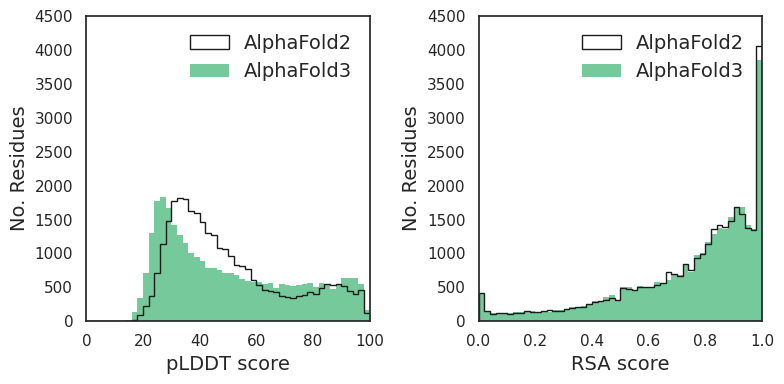

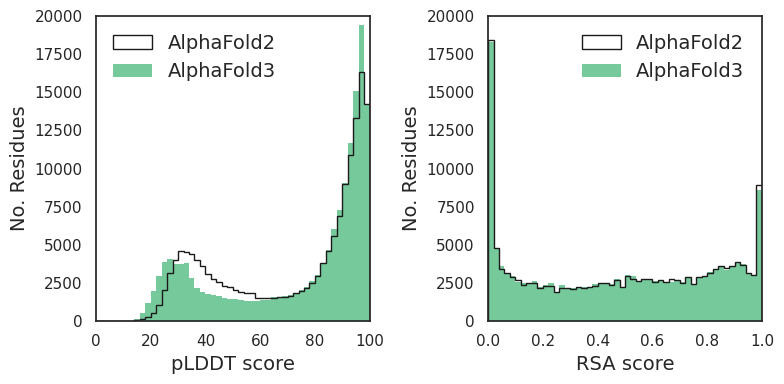

In [33]:
# plot the distribution of pLDDT, RSA, and SS for the IDR regions


plt.figure(figsize=(8,4))
sns.set_theme(style="white")
plt.subplot(1, 2, 1)
plt.hist([i*100 for i in af2_plddt_list],bins=list(np.arange(0,102,2)),density=False,histtype='step',color='k',label='AlphaFold2')
plt.hist([i*100 for i in af3_plddt_list], bins=list(np.arange(0,102,2)),color='mediumseagreen',edgecolor='none', alpha=0.7,label='AlphaFold3')

plt.xlabel('pLDDT score',fontsize=14)
plt.ylabel('No. Residues',fontsize=14)
plt.xlim(0,100)
plt.ylim(0,4500)
plt.legend(frameon=False, fontsize=14)

plt.subplot(1, 2, 2)
plt.hist(af2_rsa_list, bins=list(np.arange(0,1.02,0.02)),density=False,histtype='step',color='k',label='AlphaFold2')
plt.hist(af3_rsa_list, bins=list(np.arange(0,1.02,0.02)),color='mediumseagreen',edgecolor='none', alpha=0.7,label='AlphaFold3')

plt.xlabel('RSA score',fontsize=14)
plt.ylabel('No. Residues',fontsize=14)
plt.xlim(0,1)
plt.ylim(0,4500)
plt.legend(frameon=False, fontsize=14)

plt.tight_layout()
plt.savefig(f'{data_dir}/figures/figure_4_A_B.png', dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(8,4))
sns.set_theme(style="white")
plt.subplot(1, 2, 1)
plt.hist(all_af2_plddt_list,bins=list(np.arange(0,102,2)),density=False,histtype='step',color='k',label='AlphaFold2')
plt.hist(all_af3_plddt_list, bins=list(np.arange(0,102,2)),color='mediumseagreen',edgecolor='none', alpha=0.7,label='AlphaFold3')
plt.xlabel('pLDDT score',fontsize=14)
plt.ylabel('No. Residues',fontsize=14)
plt.xlim(0,100)
plt.ylim(0,20000)
plt.legend(frameon=False, fontsize=14)

plt.subplot(1, 2, 2)
plt.hist(all_af2_rsa_list, bins=list(np.arange(0,1.02,0.02)),density=False,histtype='step',color='k',label='AlphaFold2')
plt.hist(all_af3_rsa_list, bins=list(np.arange(0,1.02,0.02)),color='mediumseagreen',edgecolor='none',alpha=0.7,label='AlphaFold3')

plt.xlabel('RSA score',fontsize=14)
plt.ylabel('No. Residues',fontsize=14)
plt.ylim(0,20000)
plt.xlim(0,1)

plt.legend(frameon=False,fontsize=14)

plt.tight_layout()
plt.savefig(f'{data_dir}/figures/figure_S_4_A_B.png', dpi=300)
plt.show()
plt.close()

Pearson correlation coefficient: 0.8814064674006992, p-value: 1.1839556580512691e-149
Pearson correlation coefficient: 0.9559292154978347, p-value: 3.053320167809033e-243


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


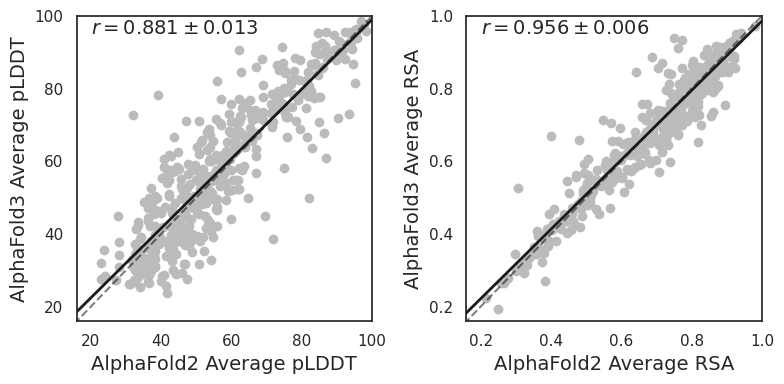

In [34]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)

r,p_value = pearsonr([i*100 for i in af2_plddt_avg_list], [i*100 for i in af3_plddt_avg_list])
print(f'Pearson correlation coefficient: {r}, p-value: {p_value}')
ci_lower, ci_upper, std = bootstrap_ci([i * 100 for i in af2_plddt_avg_list], [i*100 for i in af3_plddt_avg_list])
popt,_ = curve_fit(lambda x,a,b : a*x+b,[i*100 for i in af2_plddt_avg_list], [i*100 for i in af3_plddt_avg_list])
x = np.linspace(16,100,100)
plt.plot(x,popt[0]*x+popt[1],lw=2,label='$r={:.2f}$'.format(round(r,3)),zorder=4,color='k')
plt.scatter([i*100 for i in af2_plddt_avg_list], [i*100 for i in af3_plddt_avg_list], color='#BBBBBB')
plt.text(0.05, 0.99, '$r={:g} \pm {:g}$'.format(round(r,3),round(std,3)), transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', horizontalalignment='left')
plt.xlim(16,100)
plt.ylim(16,100)
plt.yticks(np.arange(0, 101, 20)[1:])
plt.xlabel('AlphaFold2 Average pLDDT', fontsize=14)
plt.ylabel('AlphaFold3 Average pLDDT', fontsize=14)
plt.plot([0, 100], [0, 100], linestyle='--',alpha=0.5,color='black')


plt.subplot(1, 2, 2)
r,p_value = pearsonr(af2_rsa_avg_list, af3_rsa_avg_list)
print(f'Pearson correlation coefficient: {r}, p-value: {p_value}')
ci_lower, ci_upper, std = bootstrap_ci(af2_rsa_avg_list, af3_rsa_avg_list)
popt,_ = curve_fit(lambda x,a,b : a*x+b,af2_rsa_avg_list, af3_rsa_avg_list)
x = np.linspace(0.16,1,100)
plt.plot(x,popt[0]*x+popt[1],lw=2,label='$r={:.2f}$'.format(round(r,3)),zorder=4,color='k')
plt.scatter(af2_rsa_avg_list, af3_rsa_avg_list, color='#BBBBBB')
plt.text(0.05, 0.99, '$r={:g} \pm {:g}$'.format(round(r,3),round(std,3)), transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', horizontalalignment='left')
plt.xlim(0.16,1)
plt.ylim(0.16,1)
plt.yticks(np.arange(0, 1.01, 0.2)[1:])
plt.xlabel('AlphaFold2 Average RSA', fontsize=14)
plt.ylabel('AlphaFold3 Average RSA', fontsize=14)
plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.5, color='black')
plt.tight_layout()
plt.savefig(f'{data_dir}/figures/figure_4_C_D.png', dpi=300)
plt.show()
plt.close()

# Ribbon regions in AlphaFold3

In [35]:
af3_rgs = []
af2_rgs = []
af3_structures_dir = f'{data_dir}/AF3/structures/'
af2_structures_dir = f'{data_dir}/AF2/structures/'
for i , row in tqdm(idrs_df.iterrows()):
    disprot_id = row['DisProt_id']
    start = row['start']
    end = row['end']

    file1 = make_path(af3_structures_dir,disprot_id)
    file2 = make_path(af2_structures_dir,disprot_id)

    af3_rg = calculate_rg(disprot_id, file1, start, end)
    af2_rg = calculate_rg(disprot_id, file2, start, end)

    af3_rgs.append(af3_rg)
    af2_rgs.append(af2_rg)

idrs_df['AF3_rg'] = af3_rgs
idrs_df['AF2_rg'] = af2_rgs

455it [01:12,  6.30it/s]


In [36]:
idrs_df[idrs_df['length']>700]

,DisProt_id,Uniprot_id,start,end,length,terminal,sequence,unique_id,AF3_rg,AF2_rg
194,DP04139,O14497,1,1016,1016,N,MAAQVAPAAASSLGNPPPPPPSELKKAEQQQREEAGGEAAAAAAAE...,DP04139_1_1016,77.585388,71.129662
341,DP04264,Q5SWA1,1,713,713,IDP,MEPGTGGSRKRLGPRAGFRFWPPFFPRRSQAGSSKFPTPLGPENSG...,DP04264_1_713,53.300259,49.351227
359,DP04280,P19970,1,989,989,IDP,MADSGDKSQGMRPPPFDSRGHPLPRRASPDKSITLENHRLARDTSS...,DP04280_1_989,52.338039,49.941139


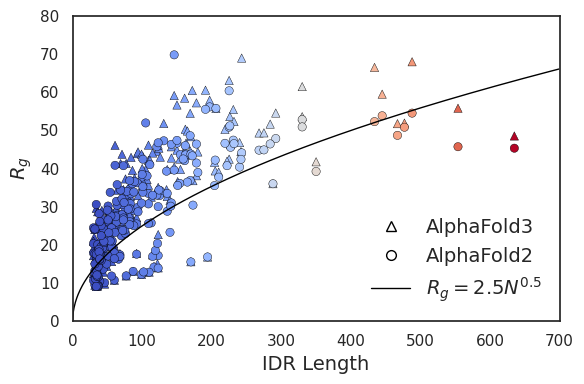

In [37]:
plt.figure(figsize=(6,4))
temp_df = idrs_df[(idrs_df['length']>=30) & (idrs_df['length']<=700)]
labels, unique = pd.factorize(temp_df['unique_id'])
plt.scatter(temp_df['length'], temp_df['AF3_rg'].tolist(), marker = '^',  edgecolors='black',linewidth=0.3,c = temp_df['length'].tolist(), cmap='coolwarm', label='AlphaFold3')
plt.scatter(temp_df['length'], temp_df['AF2_rg'].tolist(), marker = 'o',  edgecolors='black',linewidth=0.3,c = temp_df['length'].tolist(), cmap='coolwarm', label='AlphaFold2')
plt.plot([i for i in range(0,700)], [2.5*(i**0.5) for i in range(0,700)],color='black',linewidth=1, label='$R_{g} = 2.5 \sqrt{N}$')


plt.xlabel('IDR Length',fontsize=14)
plt.ylabel('$R_{g}$',fontsize=14)
plt.ylim(0,80)
plt.xlim(0,700)
# plt.title('AF3 vs AF2 Rg in IDRs')

af3_handle = mlines.Line2D([], [], marker='^', linestyle='None', 
                           markerfacecolor='white', markeredgecolor='black', 
                           markersize=7, label='AlphaFold3')

af2_handle = mlines.Line2D([], [], marker='o', linestyle='None', 
                           markerfacecolor='white', markeredgecolor='black', 
                           markersize=7, label='AlphaFold2')

line_handle = mlines.Line2D([], [], color='black', linewidth=1, label=r'$R_{g} = 2.5 N^{0.5}$')
plt.legend(handles=[af3_handle, af2_handle, line_handle], frameon=False, fontsize=14)

# plt.legend(frameon=False, fontsize=14)
plt.tight_layout()
plt.savefig(f'{data_dir}/figures/figure_5_A.png', dpi=300)
plt.show()


Pearson correlation coefficient: 0.9316658233516703, p-value: 8.031187704653057e-98


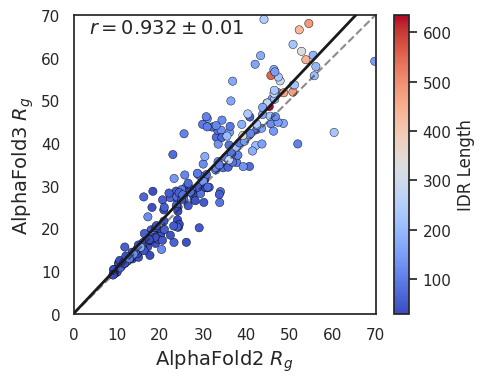

In [38]:
temp_df = idrs_df[(idrs_df['length']>=30) & (idrs_df['length']<=700)]


plt.figure(figsize=(5,4))
plt.scatter(temp_df[f'AF2_rg'].tolist(), temp_df['AF3_rg'].tolist(), edgecolors='black',linewidth=0.3, marker = 'o', c=temp_df['length'].tolist(), cmap='coolwarm')

r,p_value = pearsonr(temp_df[f'AF2_rg'].tolist(), temp_df['AF3_rg'].tolist())
print(f'Pearson correlation coefficient: {r}, p-value: {p_value}')
ci_lower, ci_upper, std = bootstrap_ci(temp_df[f'AF2_rg'].tolist(), temp_df['AF3_rg'].tolist())
popt,_ = curve_fit(lambda x,a,b : a*x+b,temp_df[f'AF2_rg'].tolist(), temp_df['AF3_rg'].tolist())
x = np.linspace(0,70,100)
plt.plot(x,popt[0]*x+popt[1],lw=2,label='$r={:.2f}$'.format(round(r,3)),zorder=4,color='k')
plt.text(0.05, 0.99, '$r={:g} \pm {:g}$'.format(round(r,3),round(std,3)), transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', horizontalalignment='left')

plt.ylim(0,70)
plt.xlim(0,70)

plt.xlabel('AlphaFold2 '+'$R_{g}$',fontsize=14)
plt.ylabel('AlphaFold3 '+'$R_{g}$',fontsize=14)
# plt.title('AF3 vs AF2 Rg in IDRs')
plt.plot([0, 71], [0, 71], 'k--',alpha=0.5)
plt.yticks(np.arange(0, 71, 10))
plt.xticks(np.arange(0, 71, 10))

plt.colorbar(label='IDR Length')

plt.tight_layout()
plt.savefig(f'{data_dir}/figures/figure_5_B.png', dpi=300)
plt.show()


# Superpositions

In [39]:
af3_structures_dir = f'{data_dir}/AF3/structures/'
af2_structures_dir = f'{data_dir}/AF2/structures/'

In [40]:
superpositions = []

proteins_list = idrs_df['DisProt_id'].unique().tolist()
    
for i, disprot_id in tqdm(enumerate(proteins_list)):
    file1 = make_path(af2_structures_dir,disprot_id)
    file2 = make_path(af3_structures_dir,disprot_id)
    tmscore_results = run_tmscore(file1, file2)
    if tmscore_results == None:
        print(disprot_id)
    else: 
        superpositions.append(tmscore_results)

superpositions_df = pd.DataFrame(superpositions)

319it [00:27, 11.79it/s]


In [47]:
superpositions_df[superpositions_df['acc'].isin(['DP04139','DP04390','DP04017','DP04016'])]

,acc,TM-score,RMSD,RMSD_folded,GDT_TS,alignment_length,common_res_length,alignment_coverage
80,DP04016,0.2163,43.647,2.06,0.1039,61,635,0.096
81,DP04017,0.1896,41.628,3.23,0.0663,31,554,0.056
140,DP04139,0.3073,66.904,1.13,0.2265,0,2285,0.000
307,DP04390,0.1574,63.141,3.31,0.0796,0,2587,0.000


In [42]:
temp_df

,DisProt_id,Uniprot_id,start,end,length,terminal,sequence,unique_id,AF3_rg,AF2_rg
5,DP03758,Q96ST2,352,548,197,Internal,DSHMDRKKFHSSDSEEEEHKKQKMDSDEDEKEGEEEKVAKRKAAVL...,DP03758_352_548,57.925762,56.177551
6,DP03759,P25454,1,77,77,N,MSQVQEQHISESQLQYGNGSLMSTVPADLSQSVVDGNGNGSSEDIE...,DP03759_1_77,41.346390,33.074310
8,DP03802,A0A1L8HGL2,738,1171,434,Internal,VETVFEMLDSVKQSLGEAMDDHSPAFMENHSVLTTSAIKHSTPSPT...,DP03802_738_1171,66.516212,52.320183
10,DP03804,Q9VVI2,71,338,268,Internal,AKQDLDGHTAPPPVVNKPTPVKLPHFSNILGKQQQLQLQQQQQQLQ...,DP03804_71_338,49.348179,44.838505
11,DP03806,Q3U8S1,293,365,73,C,VNSRRRCGQKKKLVINGGNGTVEDRKPSELNGEASKSQEMVHLVNK...,DP03806_293_365,34.512272,40.773327
...,...,...,...,...,...,...,...,...,...,...
448,DP04398,Q5ZTK4,590,759,170,Internal,SKGKERRQPNVDEIAAARIIQQILANPDCIHDDHVLINGQKLEQQF...,DP04398_590_759,15.590872,15.550171
449,DP04398,Q5ZTK4,903,1190,288,Internal,FTPRHESGYAVEPFLRMQAAKLAEVKSSIEKAQRAPDLETIFNLQN...,DP04398_903_1190,36.048889,36.041382
450,DP04399,P08062,1,111,111,N,MDPKAEGNGENITETAAGNVETSDFVNLKRQKREGVNSTGMSEIDM...,DP04399_1_111,42.244263,41.034634
451,DP04399,P08062,518,556,39,C,EPSDRYSRAFVRPEPALPPISDSRRTYESRPRGPTVNSL,DP04399_518_556,16.741158,26.141697
